In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA
import json
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgb

In [2]:
arabifile = "../data/gene_FPKM_transposed_UMR75.gzip"
metafactor = "AboveBelow"
arabidf = pd.read_parquet(arabifile)

gene_names = arabidf.columns[14:]
X_arabi = (arabidf.iloc[:, 14:]).astype("float64")
X_arabi = X_arabi.apply(lambda x: np.log2(x+1.0))
print(f"DataFrame shape: {arabidf.shape}, rnaseq data shape: {X_arabi.shape}")

arabi_pca = PCA(n_components=2).fit(X_arabi)
X_pca = arabi_pca.transform(X_arabi)
pcadf = pd.DataFrame({str(metafactor): arabidf[metafactor].values,
                        "PC1": X_pca[:, 0],
                        "PC2": X_pca[:, 1],})
fname = "../results/arabidopsis/arabidopsis_pca_coordinates.csv"
pcadf.to_csv(fname, index=False)
print(f"PCA Done. Wrote coordinates to {fname}")

arabi_meta = arabidf.iloc[:, :14]
arabi_meta["PC1"] = X_pca[:, 0]
arabi_meta["PC2"] = X_pca[:, 1]
fname = "../results/arabidopsis/arabidopsis_meta_with_pca.csv"
arabi_meta.to_csv(fname, index=False)
print(f"Wrote metadata + PCA coordinates to {fname}")

DataFrame shape: (19415, 37349), rnaseq data shape: (19415, 37335)
PCA Done. Wrote coordinates to ../results/arabidopsis/arabidopsis_pca_coordinates.csv
Wrote metadata + PCA coordinates to ../results/arabidopsis/arabidopsis_meta_with_pca.csv


In [3]:
left, right = (0.025, 0.975)
pcadf = pd.DataFrame(arabi_pca.components_[0].T, columns=["PC1"])
tails = pcadf["PC1"].quantile(q=[left, right])
left_genes = []
left_loadings = []
right_genes = []
right_loadings = []

for i, val in enumerate(pcadf["PC1"]):
    if val < tails[left]:
        left_genes.append(gene_names[i])
        left_loadings.append(val)
    elif val > tails[right]:
        right_genes.append(gene_names[i])
        right_loadings.append(val)

fn1 = "../results/arabidopsis/arabidopsis_gene_names.csv"
genes_df = pd.DataFrame({"genes": gene_names, "loadings": pcadf["PC1"].values})
genes_df.to_csv(fn1, index=False)

fn2 = "../results/arabidopsis/arabidopsis_tail_genes.csv"
tail_df = pd.DataFrame({"left_genes": left_genes, "left_loadings": left_loadings,
                        "right_genes": right_genes, "right_loadings": right_loadings})
tail_df.to_csv(fn2, index=False)

print(f"Wrote gene names to file {fn1}, and the PCA tail genes to file {fn2}")

Wrote gene names to file ../results/arabidopsis/arabidopsis_gene_names.csv, and the PCA tail genes to file ../results/arabidopsis/arabidopsis_tail_genes.csv


In [4]:
cmap = plt.get_cmap("tab10")
labels = arabidf[metafactor]
class_names = labels.unique().tolist()
labelenc = LabelEncoder().fit(class_names)
class_codes = labelenc.transform(class_names).tolist()
chex = [to_hex(cmap(i)) for i in class_codes]
lcodes = labelenc.transform(labels)
cols = [chex[ii] for ii in lcodes]

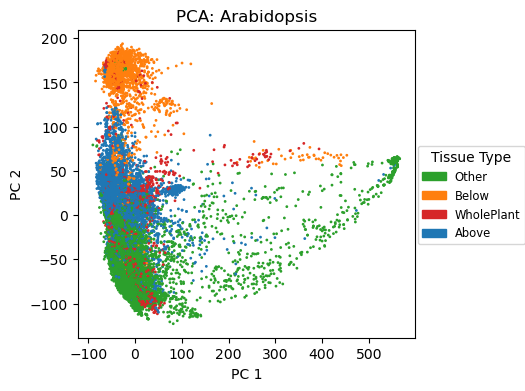

In [5]:
fig = plt.figure(figsize=(5, 4))
gs = fig.add_gridspec(nrows=1, ncols=1, height_ratios=[1.])
ax = gs.subplots()
handles = [mpl.patches.Patch(color=chex[i], label=l) for i, l in enumerate(class_names)]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cols, s=1)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("PCA: Arabidopsis")
plt.subplots_adjust(right=0.8)
fig.legend(handles=handles, loc="right", fontsize="small", borderaxespad=0, title="Tissue Type")

plt.show()

In [6]:
angiofile = "../data/Angiosperm_data_clean.csv"
angiodf = pd.read_csv(angiofile)
gene_cols = angiodf.columns[6:]
X_angio = angiodf[gene_cols]
X_angio = X_angio.apply(lambda x: np.log2(x+1.0))
print(f"Angiosperm RNAseq data shape: {X_angio.shape}")

X_arabi2 = arabidf[gene_cols]
X_arabi2 = X_arabi2.apply(lambda x: np.log2(x+1.0))
print(f"Arabidopsis RNAseq data shape: {X_arabi2.shape}")

all_labels = pd.concat([arabidf[metafactor], angiodf[metafactor]],
                        ignore_index=True)
class_names = all_labels.unique().tolist()

Angiosperm RNAseq data shape: (2671, 6328)
Arabidopsis RNAseq data shape: (19415, 6328)


In [7]:
cmap = plt.get_cmap("tab10")
labelenc = LabelEncoder().fit(class_names)
class_codes = labelenc.transform(class_names).tolist()
chex = [to_hex(cmap(i)) for i in class_codes]

larabi_codes = labelenc.transform(arabidf[metafactor])
arabi_cols = [chex[ii] for ii in larabi_codes]
langio_codes = labelenc.transform(angiodf[metafactor])
angio_cols = [chex[ii] for ii in langio_codes]

In [8]:
pca = PCA(n_components=2).fit(X_arabi2)
Xarabi_pca = pca.transform(X_arabi2)
Xangio_pca = pca.transform(X_angio)

arabi_pcadf = pd.DataFrame({"AboveBelow": arabidf[metafactor],
                             "PC1": Xarabi_pca[:, 0],
                             "PC2": Xarabi_pca[:, 1],})
fname1 = "../results/angiosperm/arabidopsis_pca_coordinates.csv"
arabi_pcadf.to_csv(fname1, index=False)

angio_pcadf = pd.DataFrame({"AboveBelow": angiodf[metafactor],
                            "PC1": Xangio_pca[:, 0],
                            "PC2": Xangio_pca[:, 1],})
fname2 = "../results/angiosperm/angiosperm_pca_coordinates.csv"
angio_pcadf.to_csv(fname2, index=False)
print(f"PCA Done. Wrote coordinates to {fname1} and {fname2}")

angio_meta = angiodf.iloc[:, :6]
angio_meta["PC1"] = Xangio_pca[:, 0]
angio_meta["PC2"] = Xangio_pca[:, 1]
fname3 = "../results/angiosperm/angiosperm_metadata_with_pca.csv"
angio_meta.to_csv(fname3, index=False)
print(f"Wrote metadata with coordinates to {fname3}")

PCA Done. Wrote coordinates to ../results/angiosperm/arabidopsis_pca_coordinates.csv and ../results/angiosperm/angiosperm_pca_coordinates.csv
Wrote metadata with coordinates to ../results/angiosperm/angiosperm_metadata_with_pca.csv


In [9]:
left, right = (0.025, 0.975)
pcadf = pd.DataFrame(pca.components_[0].T, columns=["PC1"])
tails = pcadf["PC1"].quantile(q=[left, right])
left_genes = []
left_loadings = []
right_genes = []
right_loadings = []

for i, val in enumerate(pcadf["PC1"]):
    if val < tails[left]:
        left_genes.append(gene_cols[i])
        left_loadings.append(val)
    elif val > tails[right]:
        right_genes.append(gene_cols[i])
        right_loadings.append(val)

fn1 = "../results/angiosperm/angiosperm_gene_names.csv"
genes_df = pd.DataFrame({"genes": gene_cols, "loadings": pcadf["PC1"].values})
genes_df.to_csv(fn1, index=False)

fn2 = "../results/angiosperm/angiosperm_tail_genes.csv"
tail_df = pd.DataFrame({"left_genes": left_genes, "left_loadings": left_loadings,
                        "right_genes": right_genes, "right_loadings": right_loadings})
tail_df.to_csv(fn2, index=False)

print(f"Wrote gene names to file {fn1}, and the PCA tail genes to file {fn2}")

Wrote gene names to file ../results/angiosperm/angiosperm_gene_names.csv, and the PCA tail genes to file ../results/angiosperm/angiosperm_tail_genes.csv


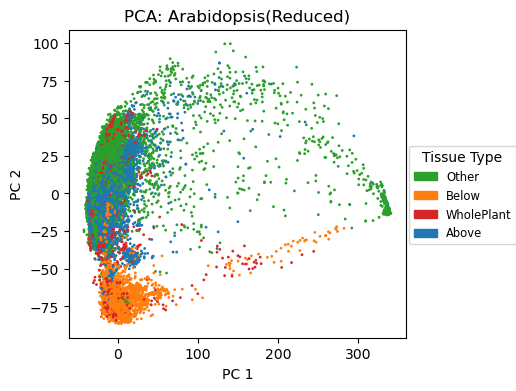

In [10]:
fig2 = plt.figure(figsize=(5, 4))
gs2 = fig2.add_gridspec(nrows=1, ncols=1, height_ratios=[1.])
ax2 = gs2.subplots()
handles = [mpl.patches.Patch(color=chex[i], label=l) for i, l in enumerate(class_names)]
ax2.scatter(Xarabi_pca[:, 0], Xarabi_pca[:, 1], c=arabi_cols, s=1.0, alpha=1.)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_title("PCA: Arabidopsis(Reduced)")
plt.subplots_adjust(right=0.8)
fig2.legend(handles=handles, loc="right", fontsize="small", borderaxespad=0, title="Tissue Type")

plt.show()

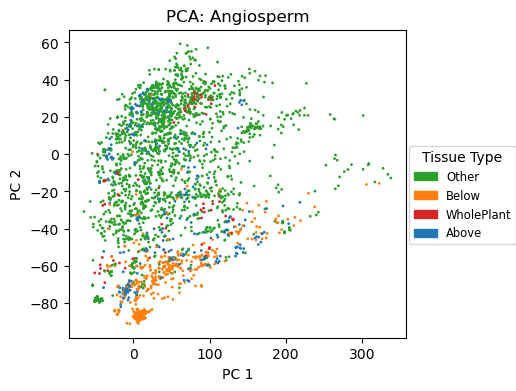

In [11]:
fig3 = plt.figure(figsize=(5, 4))
gs3 = fig3.add_gridspec(nrows=1, ncols=1, height_ratios=[1.])
ax3 = gs3.subplots()
handles = [mpl.patches.Patch(color=chex[i], label=l) for i, l in enumerate(class_names)]
ax3.scatter(Xangio_pca[:, 0], Xangio_pca[:, 1], c=angio_cols, s=1.0, alpha=1)
ax3.set_xlabel("PC 1")
ax3.set_ylabel("PC 2")
ax3.set_title("PCA: Angiosperm")
plt.subplots_adjust(right=0.8)
fig3.legend(handles=handles, loc="right", fontsize="small", borderaxespad=0, title="Tissue Type")

plt.show()

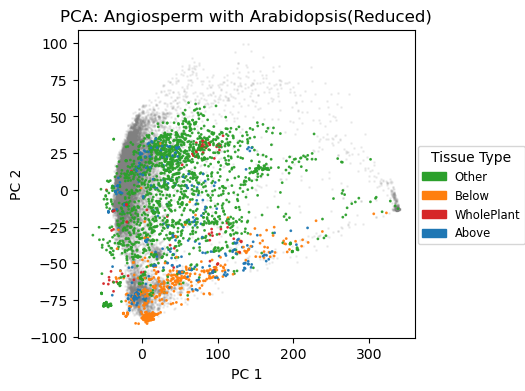

In [12]:
fig4 = plt.figure(figsize=(5, 4))
gs4 = fig4.add_gridspec(nrows=1, ncols=1, height_ratios=[1.])
ax4 = gs4.subplots()
handles = [mpl.patches.Patch(color=chex[i], label=l) for i, l in enumerate(class_names)]
ax4.scatter(Xarabi_pca[:, 0], Xarabi_pca[:, 1], c="gray", s=1.0, alpha=0.1)
ax4.scatter(Xangio_pca[:, 0], Xangio_pca[:, 1], c=angio_cols, s=1.0, alpha=0.9)
ax4.set_xlabel("PC 1")
ax4.set_ylabel("PC 2")
ax4.set_title("PCA: Angiosperm with Arabidopsis(Reduced)")
plt.subplots_adjust(right=0.8)
fig4.legend(handles=handles, loc="right", fontsize="small", borderaxespad=0, title="Tissue Type")

plt.show()